# Celltype annotation with SCSA
Single-cell transcriptomics allows the analysis of thousands of cells in a single experiment and the identification of novel cell types, states and dynamics in a variety of tissues and organisms. Standard experimental protocols and analytical workflows have been developed to create single-cell transcriptomic maps from tissues. 

This tutorial focuses on how to interpret this data to identify cell types, states, and other biologically relevant patterns with the goal of creating annotated cell maps.

Paper: [SCSA: A Cell Type Annotation Tool for Single-Cell RNA-seq Data](https://doi.org/10.3389/fgene.2020.00490)

Code: https://github.com/bioinfo-ibms-pumc/SCSA

<div class="admonition warning">
  <p class="admonition-title">Note</p>
  <p>
    The annotation with SCSA can't be used in rare celltype annotations
  </p>
</div>

In [1]:
import omicverse as ov
import scanpy as sc
ov.utils.ov_plot_set()

/Users/fernandozeng/miniforge3/envs/scbasset/lib/python3.8/site-packages/phate/__init__.py


## Loading data

The data consist of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.


In [2]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: `.h5ad`.

In [3]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading


... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


## Data preprocessing

Here, we use `ov.single.scanpy_lazy` to preprocess the raw data of scRNA-seq, it included filter the doublets cells, normalizing counts per cell, log1p, extracting highly variable genes, and cluster of cells calculation. We stored the raw counts in `count` layers, and the raw data in `adata.raw.to_adata()`.

In [4]:
adata=ov.single.scanpy_lazy(adata)
adata

filtered out 19024 genes that are detected in less than 3 cells
Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.29
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 35.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.3%
    Scrublet finished (0:00:01)
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersi

AnnData object with n_obs × n_vars = 2659 × 1865
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

## Cell annotate automatically

We create a pySCSA object from the `adata`, and we need to set some parameter to annotate correctly.

In normal annotate, we set `celltype`=`'normal'` and `target`=`'cellmarker'` or `'panglaodb'` to perform the cell annotate.

But in cancer annotate, we need to set the `celltype`=`'cancer'` and `target`=`'cancersea'` to perform the cell annotate.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p>
    The annotation with SCSA need to download the database at first. It can be downloaded automatically. But sometimes you will have problems with network errors.
  </p>
</div>

The database can be downloaded from [figshare](https://figshare.com/ndownloader/files/41369037) or [Google Drive](https://drive.google.com/drive/folders/1pqyuCp8mTXDFRGUkX8iDdPAg45JHvheF?usp=sharing). And you need to set parameter `model_path`=`'path'`

In [5]:
scsa=ov.single.pySCSA(adata=adata,
                          foldchange=1.5,
                          pvalue=0.01,
                          celltype='normal',
                          target='cellmarker',
                          tissue='All',
                          model_path='temp/pySCSA_2023_v2_plus.db'
                          
)

In the previous cell clustering we used the leiden algorithm, so here we specify that the type is set to leiden. if you are using louvain, please change it. And, we will annotate all clusters, if you only want to annotate a few of the classes, please follow `'[1]'`, `'[1,2,3]'`, `'[...]'` Enter in the format.

`rank_rep` means the `sc.tl.rank_genes_groups(adata, clustertype, method='wilcoxon')`, if we provided the `rank_genes_groups` in adata.uns, `rank_rep` can be set as `False`

In [6]:
anno=scsa.cell_anno(clustertype='leiden',
               cluster='all',rank_rep=True)

ranking genes
    finished (0:00:01)
...Auto annotate cell
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
load markers: 70276
Cluster 0 Gene number: 30
Other Gene number: 962
Cluster 1 Gene number: 307
Other Gene number: 904
Cluster 2 Gene number: 109
Other Gene number: 893
Cluster 3 Gene number: 30
Other Gene number: 959
Cluster 4 Gene number: 118
Other Gene number: 903
Cluster 5 Gene number: 469
Other Gene number: 780
Cluster 6 Gene number: 297
Other Gene number: 829
Cluster 7 Gene number: 131
Other Gene number: 906
#Cluster Type Celltype Score Times
['0', '?', 'T cell|Naive CD8+ T cell', '6.3047986095899144|5.239203707532224', 1.203388713541663]
['1', '?', 'Monocyte|Macrophage', '14.287540349588284|8.322730092135

We can query only the better annotated results

In [7]:
scsa.cell_auto_anno(adata,key='scsa_celltype_cellmarker')

...cell type added to scsa_celltype_cellmarker on obs of anndata


We can also use `panglaodb` as target to annotate the celltype

In [8]:
scsa=ov.single.pySCSA(adata=adata,
                          foldchange=1.5,
                          pvalue=0.01,
                          celltype='normal',
                          target='panglaodb',
                          tissue='All',
                          model_path='temp/pySCSA_2023_v2_plus.db'
                          
)

In [9]:
res=scsa.cell_anno(clustertype='leiden',
               cluster='all',rank_rep=True)
res.head()

ranking genes
    finished (0:00:01)
...Auto annotate cell
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
load markers: 70276
Cluster 0 Gene number: 30
Other Gene number: 529
Cluster 1 Gene number: 307
Other Gene number: 485
Cluster 2 Gene number: 109
Other Gene number: 472
Cluster 3 Gene number: 30
Other Gene number: 521
Cluster 4 Gene number: 118
Other Gene number: 482
Cluster 5 Gene number: 469
Other Gene number: 442
Cluster 6 Gene number: 297
Other Gene number: 505
Cluster 7 Gene number: 131
Other Gene number: 489
#Cluster Type Celltype Score Times
['0', '?', 'T Memory Cells|T Cells', '3.0845205962538094|2.598843978171837', 1.1868817913507923]
['1', '?', 'Monocytes|Neutrophils', '3.229769498252461|2.839240688845

,Cell Type,Z-score,Cluster
0,T Memory Cells,3.084521,0
1,T Cells,2.598844,0
2,T Regulatory Cells,0.977936,0
3,T Helper Cells,0.977936,0
4,Decidual Cells,0.977936,0


We can query only the better annotated results

In [10]:
scsa.cell_anno_print()

Cluster:0	Cell_type:T Memory Cells|T Cells	Z-score:3.085|2.599
Cluster:1	Cell_type:Monocytes|Neutrophils	Z-score:3.23|2.839
Cluster:2	Cell_type:NK Cells|Decidual Cells	Z-score:4.067|3.018
Cluster:3	Cell_type:T Cells|T Regulatory Cells	Z-score:2.393|1.812
Cluster:4	Cell_type:B Cells Naive|B Cells Memory	Z-score:4.432|4.054
Cluster:5	Cell_type:Monocytes|Macrophages	Z-score:3.481|2.731
Cluster:6	Cell_type:Dendritic Cells|Langerhans Cells	Z-score:4.054|3.703
Cluster:7	Cell_type:Platelets|Erythroid-like And Erythroid Precursor Cells	Z-score:6.737|3.55


In [11]:
scsa.cell_auto_anno(adata,key='scsa_celltype_panglaodb')

...cell type added to scsa_celltype_panglaodb on obs of anndata


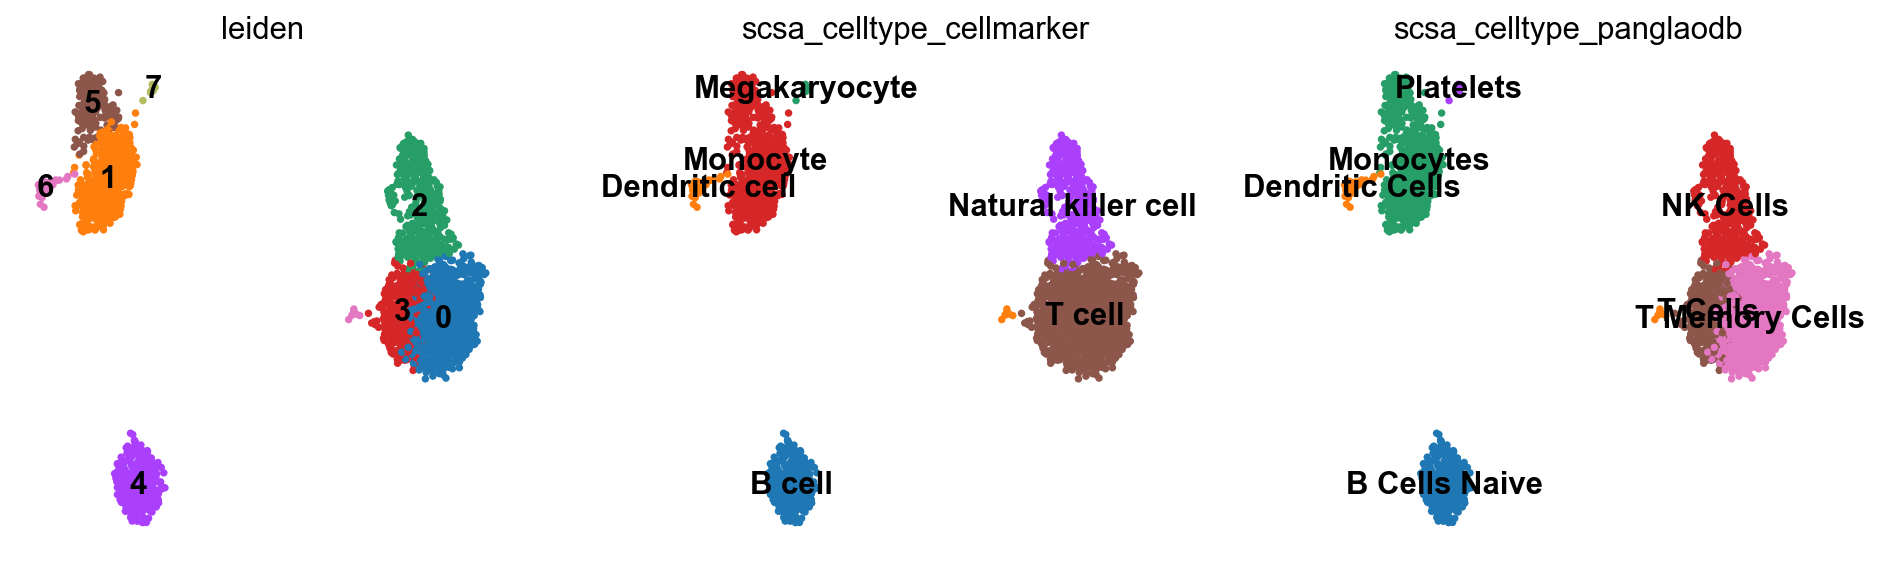

In [12]:
sc.pl.umap(adata, color=['leiden','scsa_celltype_cellmarker','scsa_celltype_panglaodb'], legend_loc='on data', frameon=False)

(<Figure size 240x320 with 1 Axes>,
 <AxesSubplot: xlabel='leiden', ylabel='Cells per Stage'>)

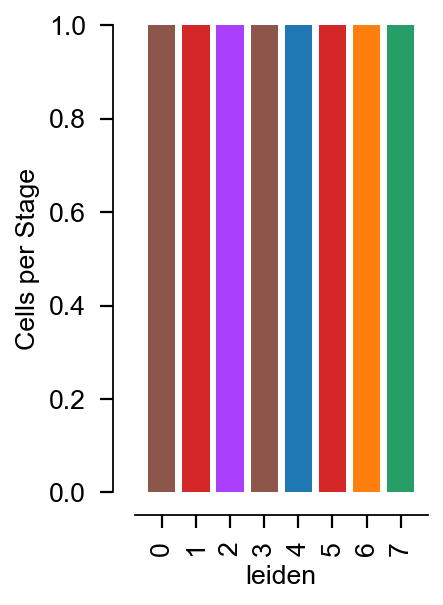

In [21]:
ov.utils.plot_cellproportion(adata=adata,celltype_clusters='scsa_celltype_cellmarker',
                    visual_clusters='leiden',
                    visual_name='leiden',figsize=(3,4))

(<Figure size 480x320 with 2 Axes>,
 [<AxesSubplot: xlabel='X_umap1', ylabel='X_umap2'>, <AxesSubplot: >])

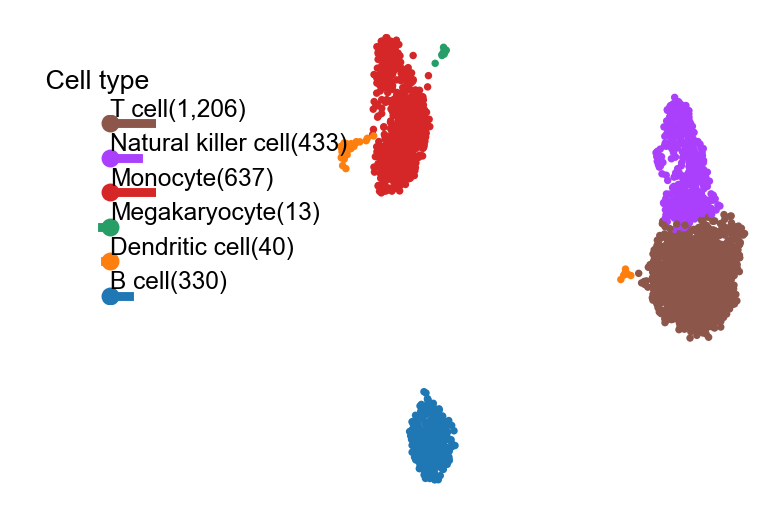

In [14]:
ov.utils.plot_embedding_celltype(adata,figsize=None,basis='X_umap',
                            celltype_key='scsa_celltype_cellmarker',title='    Cell type',
                            celltype_range=(2,6),
                            embedding_range=(4,10),)

## Cell annotate manually

In order to compare the accuracy of our automatic annotations, we will here use marker genes to manually annotate the cluster and compare the accuracy of the pySCSA and manual.

We need to prepare a marker's dict at first

In [15]:
res_marker_dict={
    'Megakaryocyte':['ITGA2B','ITGB3'],
    'Dendritic cell':['CLEC10A','IDO1'],
    'Monocyte' :['S100A8','S100A9','LST1',],
    'Macrophage':['CSF1R','CD68'],
    'B cell':['MS4A1','CD79A','MZB1',],
    'NK/NKT cell':['GNLY','KLRD1'],
    'CD8+T cell':['CD8A','CD8B'],
    'Treg':['CD4','CD40LG','IL7R','FOXP3','IL2RA'],
    'CD4+T cell':['PTPRC','CD3D','CD3E'],

}

We then calculated the expression of marker genes in each cluster and the fraction

    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: Megakaryocyte, Dendritic cell, Monocyte, etc.


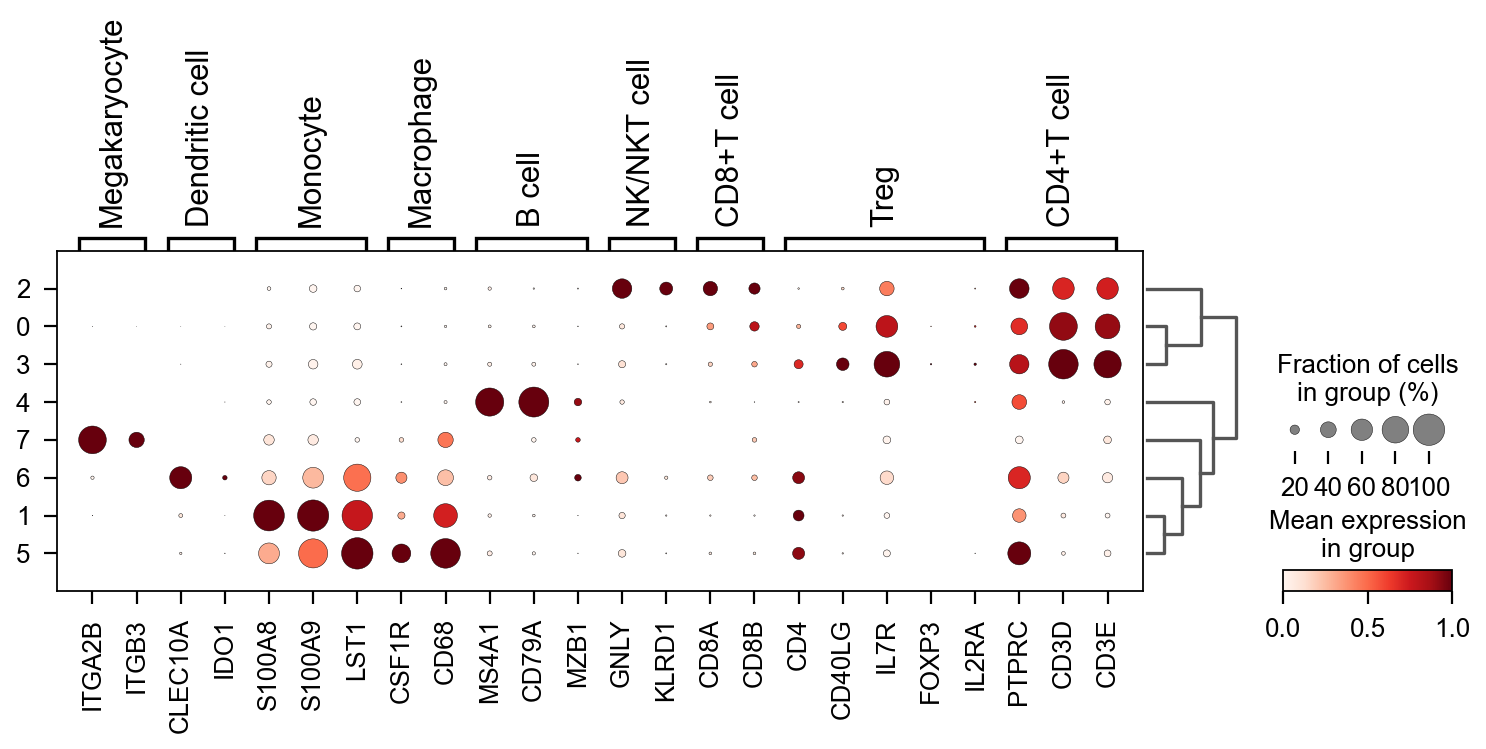

In [16]:
sc.tl.dendrogram(adata,'leiden')
sc.pl.dotplot(adata, res_marker_dict, 'leiden', dendrogram=True,standard_scale='var')

Based on the dotplot, we name each cluster according `ov.single.scanpy_cellanno_from_dict`

In [17]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'T cell',
     '1': 'Monocyte',
     '2': 'Natural killer T (NKT) cell',#Germ-cell(Oid)
     '3': 'T cell',#Germ-cell(Oid)
     '4': 'B cell',
     '5': 'Macrophage',
     '6': 'Dendritic cell',
     '7': 'Megakaryocyte',

}
ov.single.scanpy_cellanno_from_dict(adata,anno_dict=cluster2annotation,
                                       clustertype='leiden')

...cell type added to major_celltype on obs of anndata


## Compare the pySCSA and Manual

We can see that the auto-annotation results are almost identical to the manual annotation, the only difference is between monocyte and macrophages, but in the previous auto-annotation results, pySCSA gives the option of `monocyte|macrophage`, so it can be assumed that pySCSA performs better on the pbmc3k data

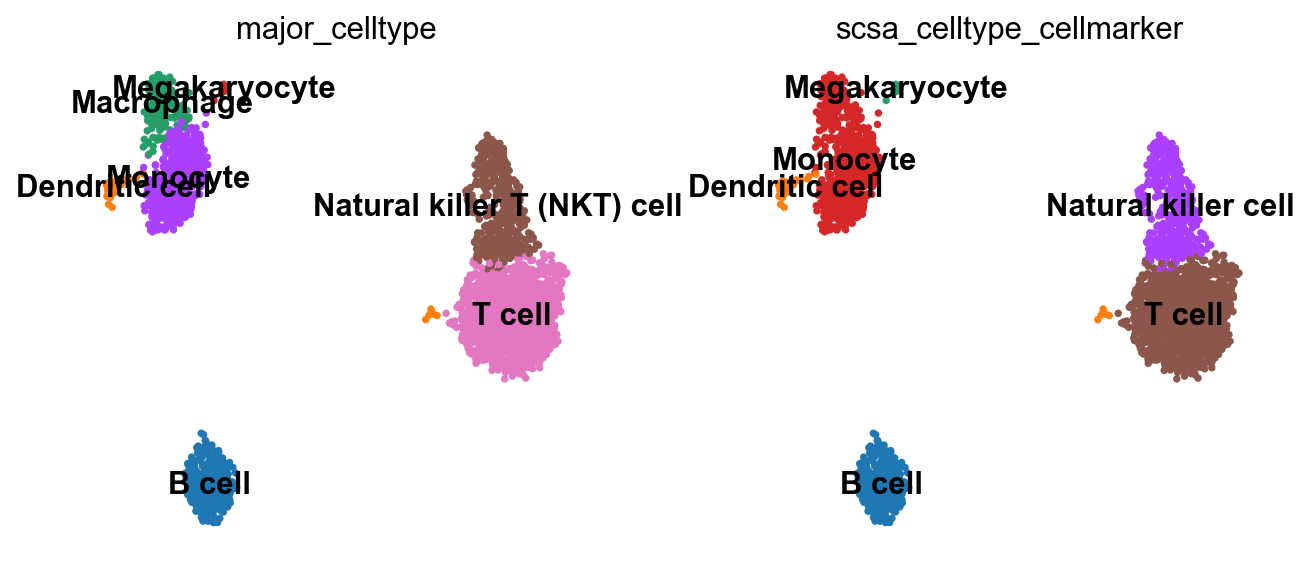

In [18]:
sc.pl.umap(adata, color=['major_celltype','scsa_celltype_cellmarker'], 
           legend_loc='on data', frameon=False)

We can use `get_celltype_marker` to obtain the marker of each celltype

In [19]:
marker_dict=ov.single.get_celltype_marker(adata,clustertype='scsa_celltype_cellmarker')
marker_dict.keys()

...get cell type marker
ranking genes
    finished (0:00:01)


dict_keys(['B cell', 'Dendritic cell', 'Megakaryocyte', 'Monocyte', 'Natural killer cell', 'T cell'])

## The tissue name in database

For annotation of cell types in specific tissues, we can query the tissues available in the database using `get_model_tissue`.

In [20]:
scsa.get_model_tissue()

Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
########################################################################################################################
------------------------------------------------------------------------------------------------------------------------
Species:Human      Num:298       
------------------------------------------------------------------------------------------------------------------------
  1: Abdomen                              2: Abdominal adipose tissue             3: Abdominal fat pad                  
  4: Acinus                               5: Adipose tissue                       6: Adrenal gland                      
  7: Adventitia                           8: Airway                               9: Airway epithelium                  
 10: Allocortex                          11: Alveolus                          